In [1]:
import os
import json
import pandas as pd
import langchain
import openai
import numpy as np
import requests

OpenAIKey = "Your-Api-key"



Prompt = """
The reviews you see are for a product that we sell.
Give most prevalent examples in bullets wether Positive or Negative feedback
Next to each feedback is a quote that describes the feedback
What do you suggest we focus on improving? 
use this prompt:

Positive feedback:
1 - 5 Feedbacks  " Quote " 

Negative:
1-5 Feedbacks " Quote " 

What to Improve:

"improve ...."

"""

#Vector dimension: 768

Loading JSON's from Google-Drive


In [2]:

url = 'https://geenie-c7e6851.svc.us-central1-gcp.pinecone.io/vectors/delete?ids=&namespace=p1'
headers = {'Api-Key': 'Your-Api-key'}

response = requests.delete(url, headers=headers)
print(response.status_code)


400


In [246]:
import re
import requests
import json


def read_json_from_google_drive_link(drive_link):
    file_id = drive_link.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"
    response = requests.get(download_url)
    content = response.content.decode('utf-8')

    if response.status_code != 200:
        raise requests.exceptions.HTTPError(response)

    json_data = json.loads(content)

    return json_data


drive_link = "https://drive.google.com/drive/u/1/folders/1he1f9OD9Kp9FP3URiDDGS4RXhiGVl7iW"
response = requests.get(drive_link)
html_text = response.text

# Extract file IDs using regular expression
file_ids = re.findall(r"/file/d/([^/]+)", html_text)

# Storing the json files from the drive into a list for easier access.
json_list = []

for file_id in file_ids:
    json_data = read_json_from_google_drive_link(f"https://drive.google.com/file/d/{file_id}/view?usp=sharing")
    if json_data not in json_list:  # Check if the data is already in the list
        json_list.append(json_data)

Transfering all JSON uploaded from Google-Drive into Dataframes

In [248]:
dataframes = [] # Creating a DataFrame list


max_text_length=600     
def truncate_review(text):          # Function to setlimit on text length
    return text[:max_text_length]


for json_data in json_list:
    df = pd.DataFrame(json_data)
    
    # Renaming
    new_columns = {
    0: 'Name',1: 'Key Words',2: 'Text',3: 'Stars'
    }
    df.rename(columns=new_columns, inplace=True)
    #
    
    #Removing Unwanted words for the model to be easier to understand and analyze.
    df['Text'] = df['Text'].str.replace('The media could not be loaded.\n                \n\n\n\n\xa0', '')
    df['truncated']=df.apply(lambda row: truncate_review(row['Text']),axis=1) # Applying "truncate_review" on each DataFrame
    dataframes.append(df)



Importing NLTK (Vader) Progress.  --- Sentiment Analysis 
+ Function to decide whether Positive/Negative/Neutral


In [265]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


## Creating a function that will take each text from 'Text' column and apply their sentiment compound score to the new column
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

Importing Embedding libraries 
+ Creating a new Embeeded Column and uploading embedded values

In [251]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()


for df in dataframes:

    df['embeddings'] = df.apply(lambda row: embeddings.embed_query(row['truncated']), axis=1)   # Creating a new Column "Embeddings" with embedded values of "truncated" column

Import Pinecone using their API. 
+ Storing vectors in
+ Importing Langchain QA Model and OpenAI use

In [267]:
import pinecone
from langchain.vectorstores import Pinecone

PINECONE_API_KEY = 'Your-Api-key'
PINECONE_ENV = 'us-central1-gcp'

pinecone.init(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)


#################

from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
chat = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.0, openai_api_key=OpenAIKey)

query_results = [] ## Saving all query results


Running in a loop on all dataframes
+ Making "Truncated" column into a list
+ Uploading all vectors to Pipecone with a unique namespace so we can identify which is what
+ Using NLTK Vader's Sentiment Analysis and creating a new column that shows the result
+ Returning all queries into a list (Goods Bads and what's to improve in your product based on your feedbacks)

In [272]:
for i, df in enumerate(dataframes):
    texts = df['truncated'].tolist()
    namespace = 'p' + str(i + 1)  # Generate the namespace dynamically
    vstore = Pinecone.from_texts(texts, embeddings, index_name='geenie', namespace=namespace)
    review_chain = RetrievalQA.from_chain_type(llm=chat, chain_type="stuff", retriever=vstore.as_retriever())
    df['Sentiment Score'] = df['Text'].apply(analyze_sentiment)

    result = review_chain.run(Prompt)
    query_results.append(result)

DataFrame 1 Information:

Positive feedback:
- Amazing color displays that more than once had me sitting back thinking "wow, that is so epic."
- Keys have the perfect crunch, love that I can actually set a color (leave it on purple).
- First keyboard that has multiple colors and lighting types.
- The switches are solid.
- I liked all the different color options and how you can change the modes of the colors.

Negative feedback:
- Did I know how to change a switch? No, BUT it was easy. They send it with all the tools to replace the switch, which was kind of a giveaway that I may have to replace one sooner or later - I was just hoping for later.
- Only bad thing to say about it is that it didn't come with a wrist support thing.
- The noises from the keys are very clicky sounding so if you like ASMR sounds you'll probably like this.
- I plan on replacing some of the keys with some other cherry mx switches. Switch replacement looks to be straightforward, unlike my Logitech g710.
- Otherwis

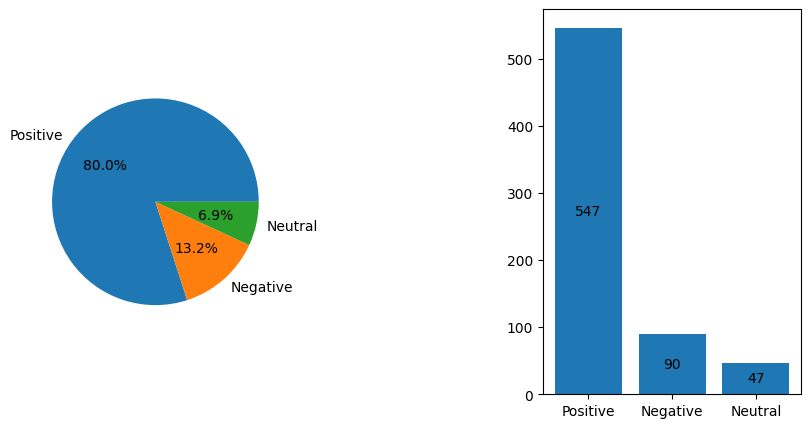



DataFrame 2 Information:

Positive feedback:
- The light on this keyboard are very nice and there are many different settings to choose from.
- The keys are very crisp and the feeling is great.
- It looks absolutely gorgeous and very solid.
- The light functions are superb.
- The keys provide wonderful tactile feedback.

Negative feedback:
- My left shift key is sticky and dull.
- The spacebar is particularly thunderous.
- The keys are very tall and it is very easy to accidentally press a wrong key.
- It doesn't take very much of a tap to press down the key, so this happens a lot.
- You need to get all 104 keys.

What to improve:
- Improve the quality control to avoid sticky and dull keys.
- Improve the design of the spacebar to reduce the noise.
- Improve the key height and sensitivity to reduce accidental key presses.


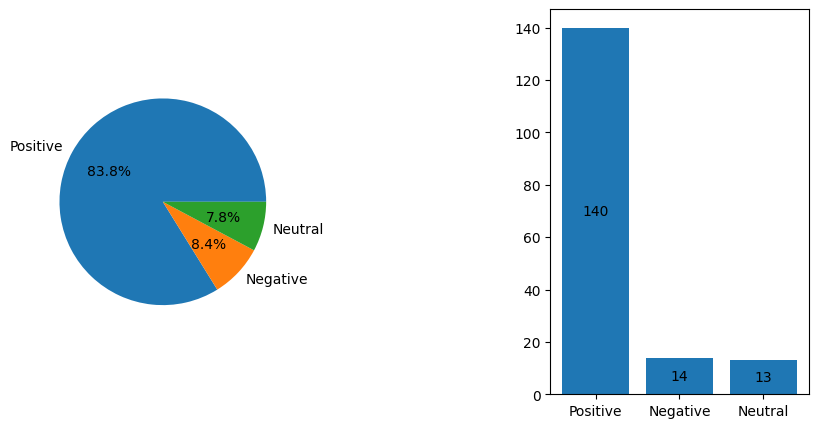



DataFrame 3 Information:

Positive feedback:
1. Love the RGB lights, they are adjustable, and at the max setting, they are very bright.
2. The curvature of the individual keys makes it easier to keep your fingers from moving around on accident.
3. It looks very cool!
4. The manufacturer had a replacement at my door in just a couple of days.
5. I don't like mechanic keyboard and the sound, this one is perfect.

Negative feedback:
1. The keyboard is moderately quiet, not "whisper silent" as it says in the description.
2. The wrist rest is too low to provide any support for the wrists, so your hands are bent at an awkward angle during usage.
3. In both the original AND replacement keyboards, I immediately realized the CTRL key, when pressed in fairly rapid succession, would skip every third press.

What to improve:
Improve the wrist rest to provide better support for the wrists and fix the CTRL key issue.


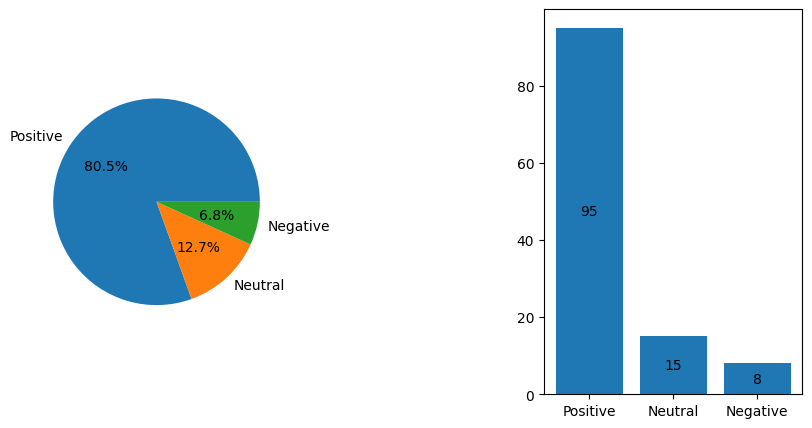



DataFrame 4 Information:

Positive feedback:
- Amazing aluminum case
- Good stock switch options
- Surprisingly good stock keycaps
- Great value for just over $50
- Heavy case that doesn't slide around

Negative feedback:
- Very difficult to tune stabilizers
- Limited options for future switch upgrades with Gateron optical standard
- Chalky feeling of the keycaps
- Noisy stabilizers
- Inconsistent key presses

What to improve:
- Improve stabilizers
- Increase options for future switch upgrades
- Improve consistency of key presses


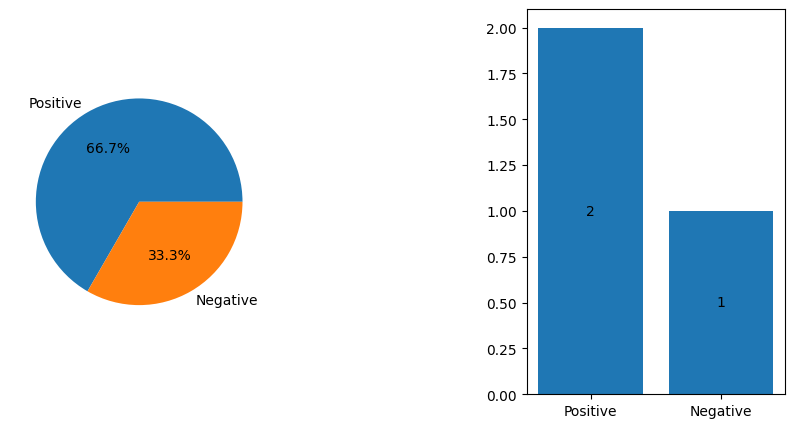

In [301]:
import matplotlib.pyplot as plt

# Create a list of dataframes
# Iterate over the dataframes
for i, df in enumerate(dataframes):
    # Print the dataframe information
    print(f"DataFrame {i+1} Information:\n")
    # Count the number of positive, negative, and neutral sentiments
    sentiment_counts = df['Sentiment Score'].value_counts()
    print(query_results[i+2])

    # Get the labels and counts
    labels = sentiment_counts.index
    counts = sentiment_counts.values

    # Create a grid of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the pie chart
    ax1.pie(counts, labels=labels, autopct='%1.1f%%')

    # Plot the bar diagram
    ax2.bar(labels, counts)

    # Add counts on top of the bars
    for j, count in enumerate(counts):
        ax2.text(j, count/2, str(count), ha='center', va='center')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=1)

    # Display the plots
    plt.show()
    print("\n")  # Add a line break between each dataframe
